## Initial comparison 

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
os.listdir('.')

['.ipynb_checkpoints',
 'custom_attention.py',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_128-epochs-7',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_16-epochs-7',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_256-epochs-7',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_32-epochs-7',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_64-epochs-7',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_128-epochs-5',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_128-epochs-7',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_16-epochs-5',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_16-epochs-7',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_256-epochs-5',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_256-epochs-7',
 'longformer-base-512-text-classification-imdb-adamw

In [42]:
def extract_att_win_size(folder_name, contain):
    if 'roberta' in folder_name:
        return 512
    if contain == 'emotion':
        return int(folder_name.split('_')[-1])
    else:
        return int(folder_name.split('_')[-1].split('-')[0])

def plot_data(contain, metric):
    subfolders = [f.path for f in os.scandir('.') if f.is_dir() and contain in f.path]
    subfolders = sorted(subfolders, key=lambda x: extract_att_win_size(x, contain))

    if contain == 'epochs-7':
        subfolders = [x for x in subfolders if 'emotion' not in x]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for idx, subfolder in enumerate(subfolders):
        with open(os.path.join(subfolder, 'summary.json'), 'r') as f:
            summary = json.load(f)
        
        with open(os.path.join(subfolder, 'test_results.json'), 'r') as f:
            test_results = json.load(f)
        
        train_losses = pd.read_csv(os.path.join(subfolder, 'train_losses.csv'))
        val_losses = pd.read_csv(os.path.join(subfolder, 'val_losses.csv'))
        
        att_win_size = extract_att_win_size(subfolder, contain)
        
        axes[idx].plot(train_losses['epoch'], train_losses['train_' + metric], label='Train '+ metric)
        axes[idx].plot(val_losses['epoch'], val_losses['eval_' + metric], label='Validation ' + metric)

        if att_win_size == 512:
            att_win_size = 'n^2'
        main_title = f"Attention Window Size: {att_win_size}"
        subtitle = (f"Test {metric}: {test_results['test_' + metric]:.3f}, Samples/sec: {summary['samples/sec']:.2f}, "
                    f"GPU Memory: {summary['gpu_memory']} MB")
        
        axes[idx].set_title(main_title, fontsize=14, pad=20)
        axes[idx].text(0.5, 1.05, subtitle, ha='center', va='center', transform=axes[idx].transAxes, fontsize=10, alpha=0.9)
        
        if metric == 'loss':
            axes[idx].set_ylim(0,0.7)
        else:
            axes[idx].set_ylim(0.7,1)
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()
    dataset = subfolder.split('-')[5]
    fig.suptitle(f'Dataset: {dataset}', fontsize=16)

    plt.tight_layout(pad=1)
    plt.show()

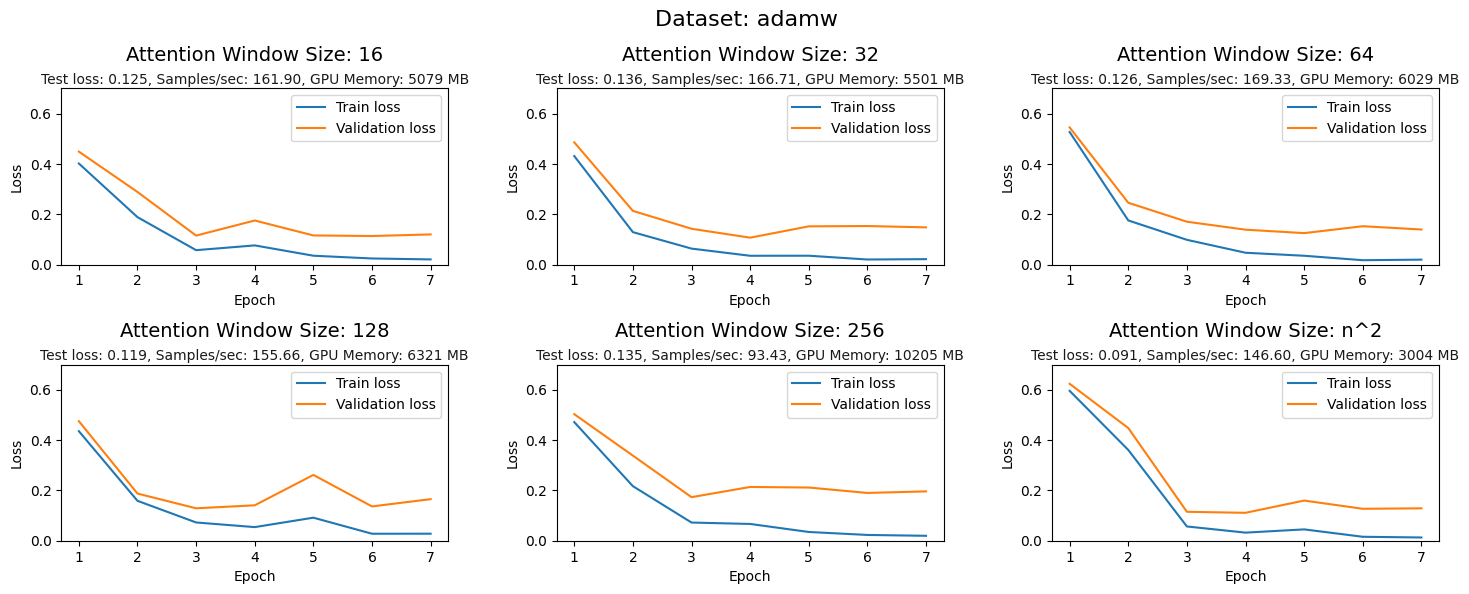

In [43]:
plot_data('emotion', 'loss')

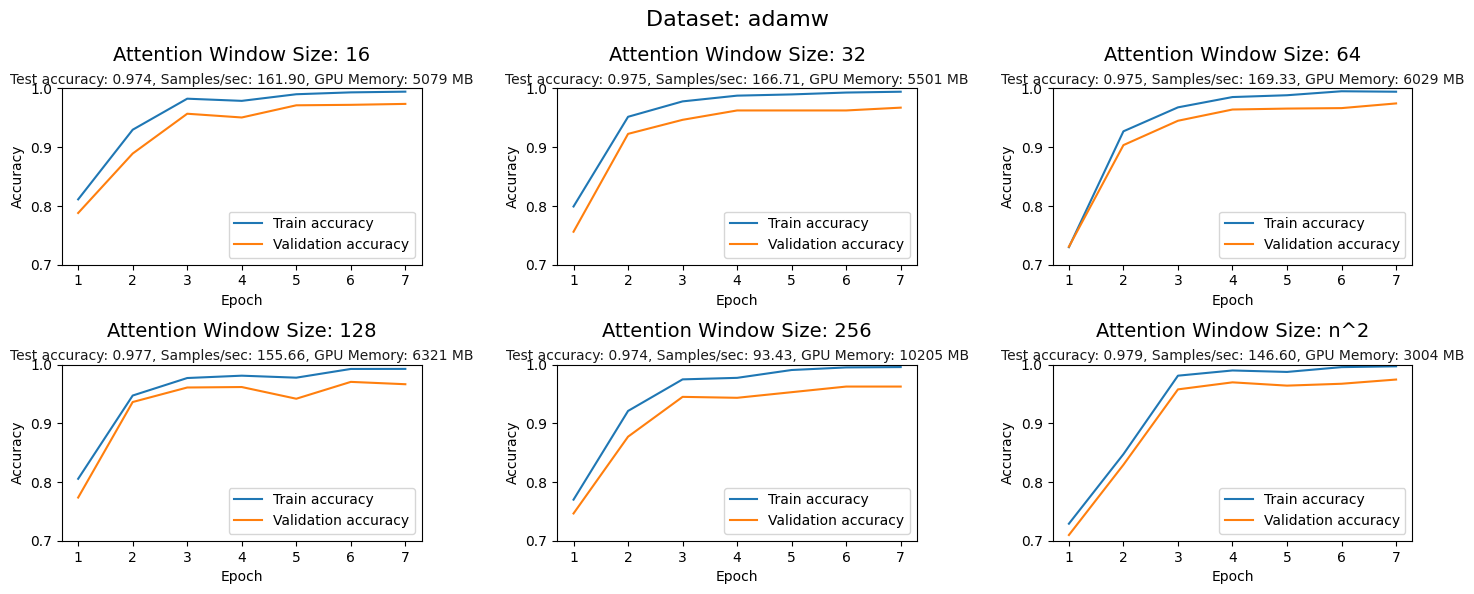

In [44]:
plot_data('emotion', 'accuracy')

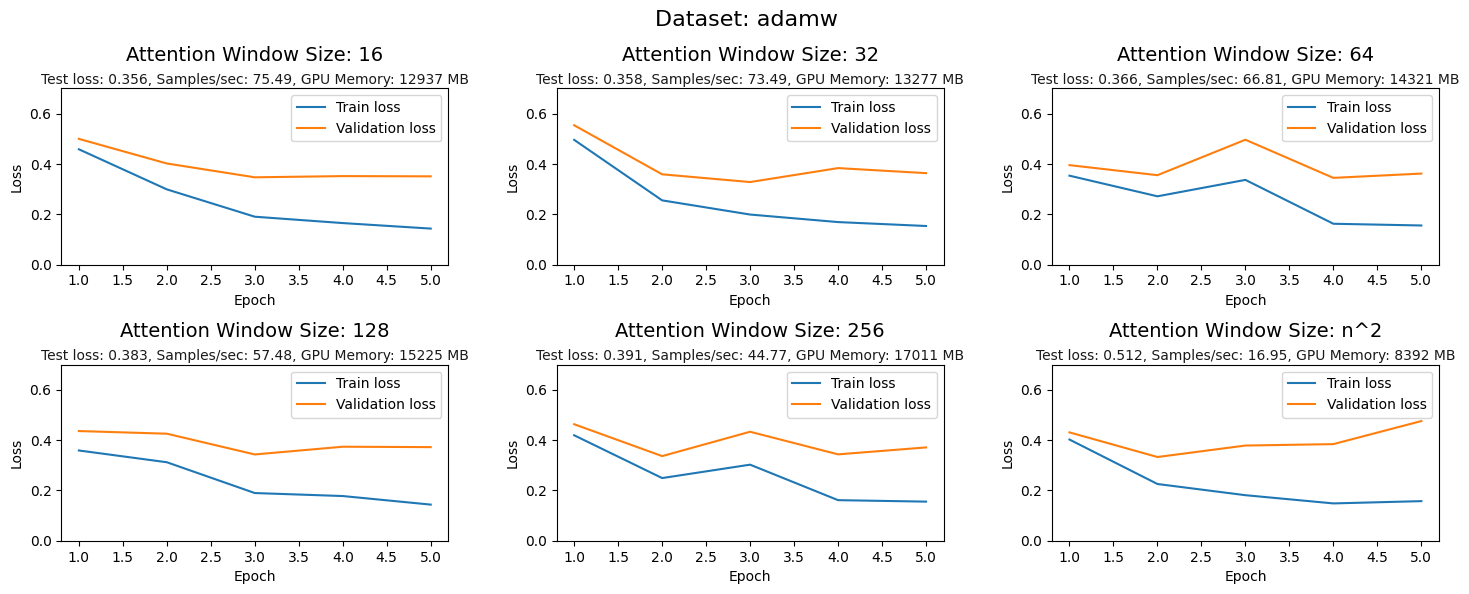

In [45]:
plot_data('epochs-5', 'loss')

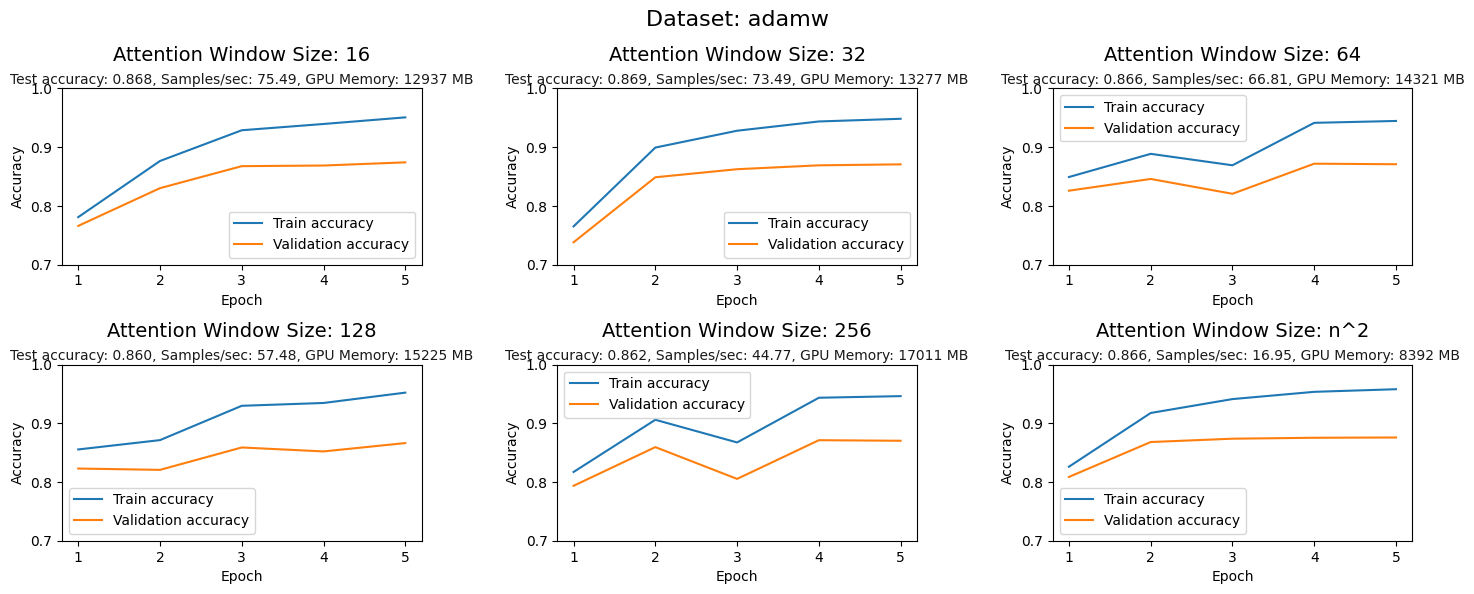

In [46]:
plot_data('epochs-5', 'accuracy')

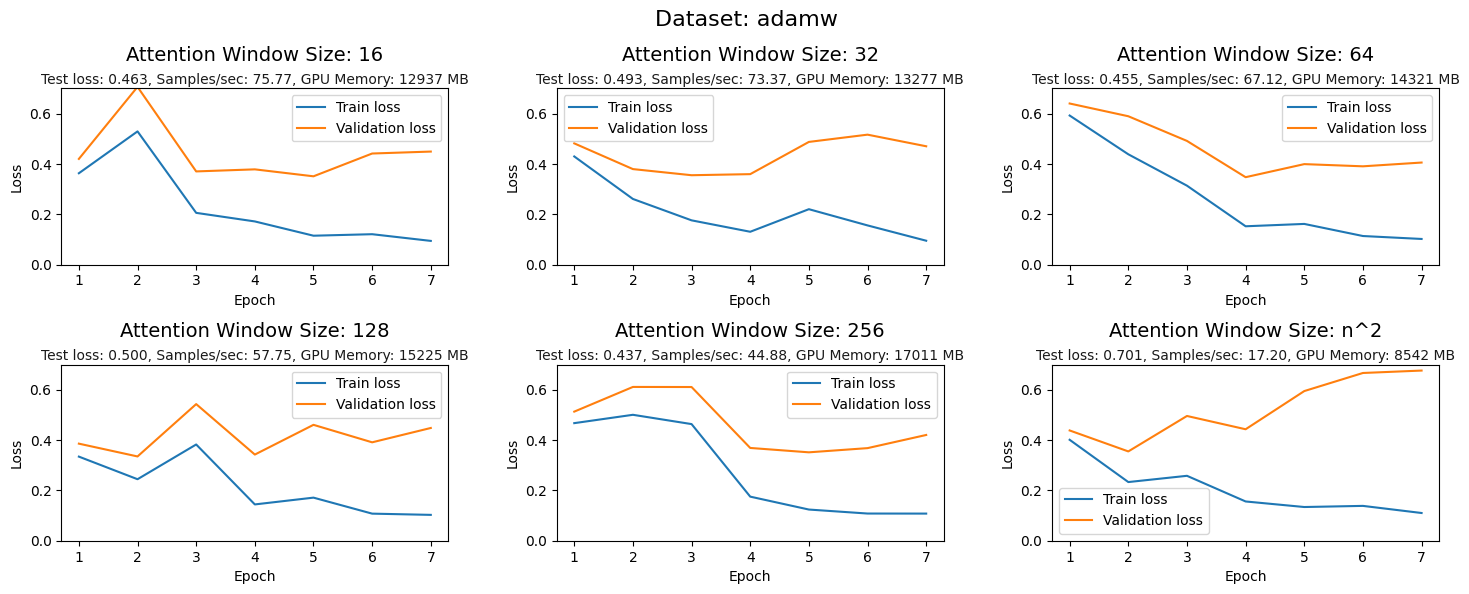

In [47]:
plot_data('epochs-7', 'loss')

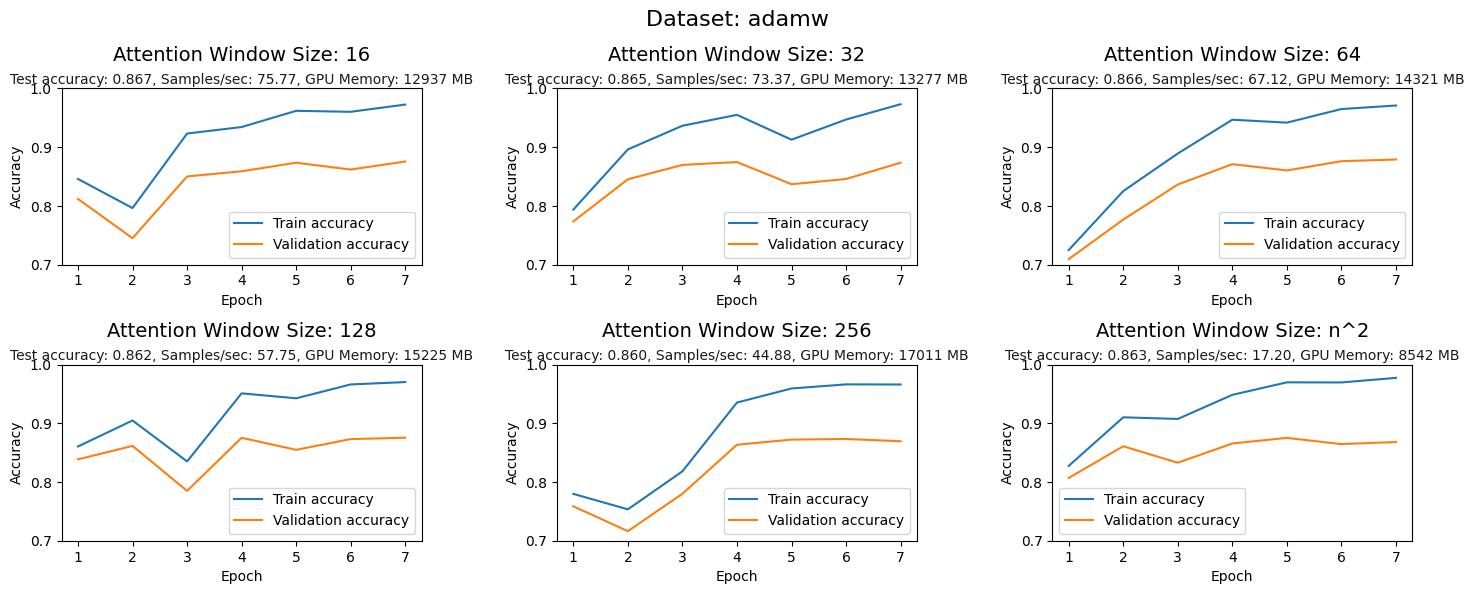

In [48]:
plot_data('epochs-7', 'accuracy')

### Training process AdamW

In [12]:
def plot_comparinson_global(contain, metric):
    if isinstance(contain, str):
        contain = [contain]

    subfolders = [f.path for f in os.scandir('.') if f.is_dir() and all(c in f.path for c in contain)]
    subfolders = sorted(subfolders, key=lambda x: extract_att_win_size(x, contain))

    subfolders_with_global = [sf for sf in subfolders if 'no_global' not in sf]
    subfolders_without_global = [sf for sf in subfolders if 'no_global' in sf]

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    ax_no_global, ax_with_no_global = axes

    def plot_subfolders(subfolders, ax, title):
        for subfolder in subfolders:
            with open(os.path.join(subfolder, 'summary.json'), 'r') as f:
                summary = json.load(f)
            
            with open(os.path.join(subfolder, 'test_results.json'), 'r') as f:
                test_results = json.load(f)
            
            train_losses = pd.read_csv(os.path.join(subfolder, 'train_losses.csv'))
            val_losses = pd.read_csv(os.path.join(subfolder, 'val_losses.csv'))
            
            att_win_size = extract_att_win_size(subfolder, contain)
            
            ax.plot(train_losses['epoch'], train_losses['train_' + metric], label=f'Train {metric}, Attn {att_win_size}')
            ax.plot(val_losses['epoch'], val_losses['eval_' + metric], label=f'Val {metric}, Attn {att_win_size}')

        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylim(0, 0.8)
        ax.set_ylabel(metric.capitalize())
        ax.legend()

    plot_subfolders(subfolders_with_global, ax_no_global, 'Subfolders with global')
    plot_subfolders(subfolders_without_global, ax_with_no_global, 'Subfolders without global')

    if subfolders:
        dataset = subfolders[0].split('-')[5]
        fig.suptitle(f'Dataset: {dataset}', fontsize=16)

    plt.tight_layout(pad=1)
    plt.show()

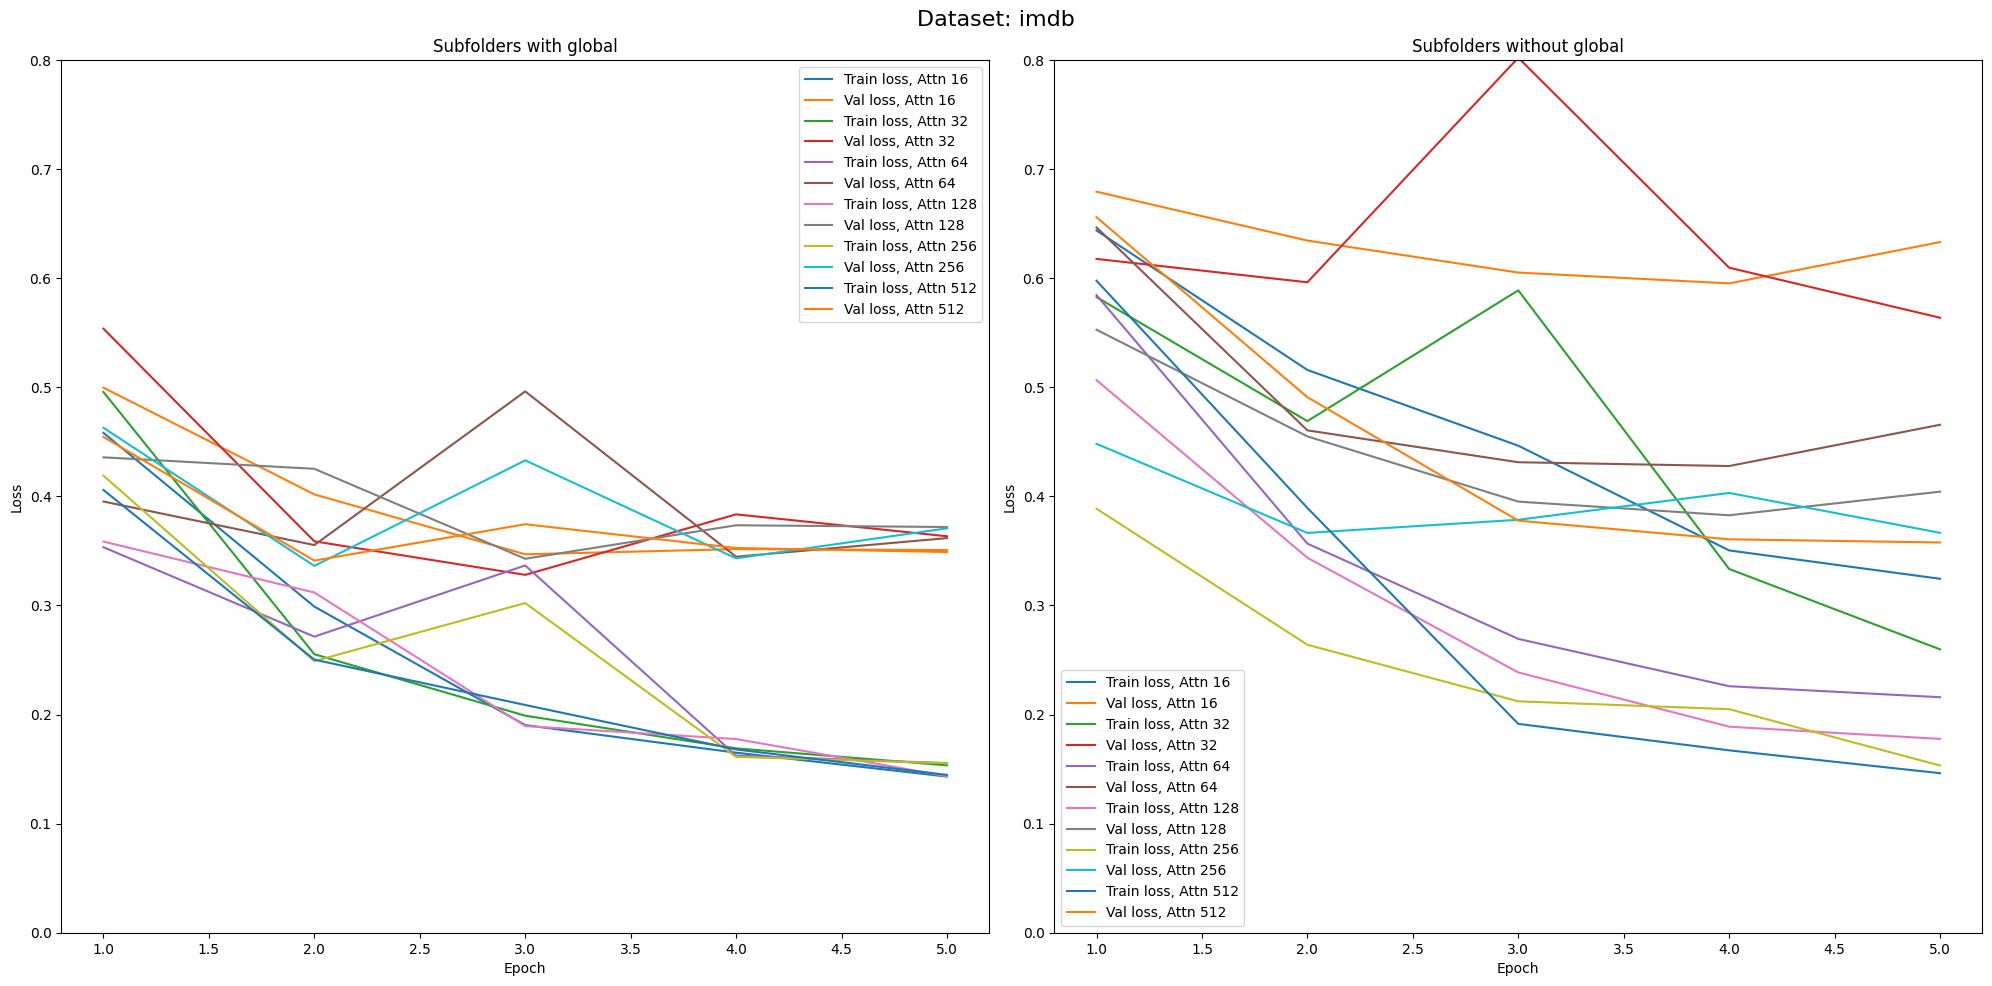

In [15]:
plot_comparinson_global(['imdb', 'epochs-5'], 'loss')

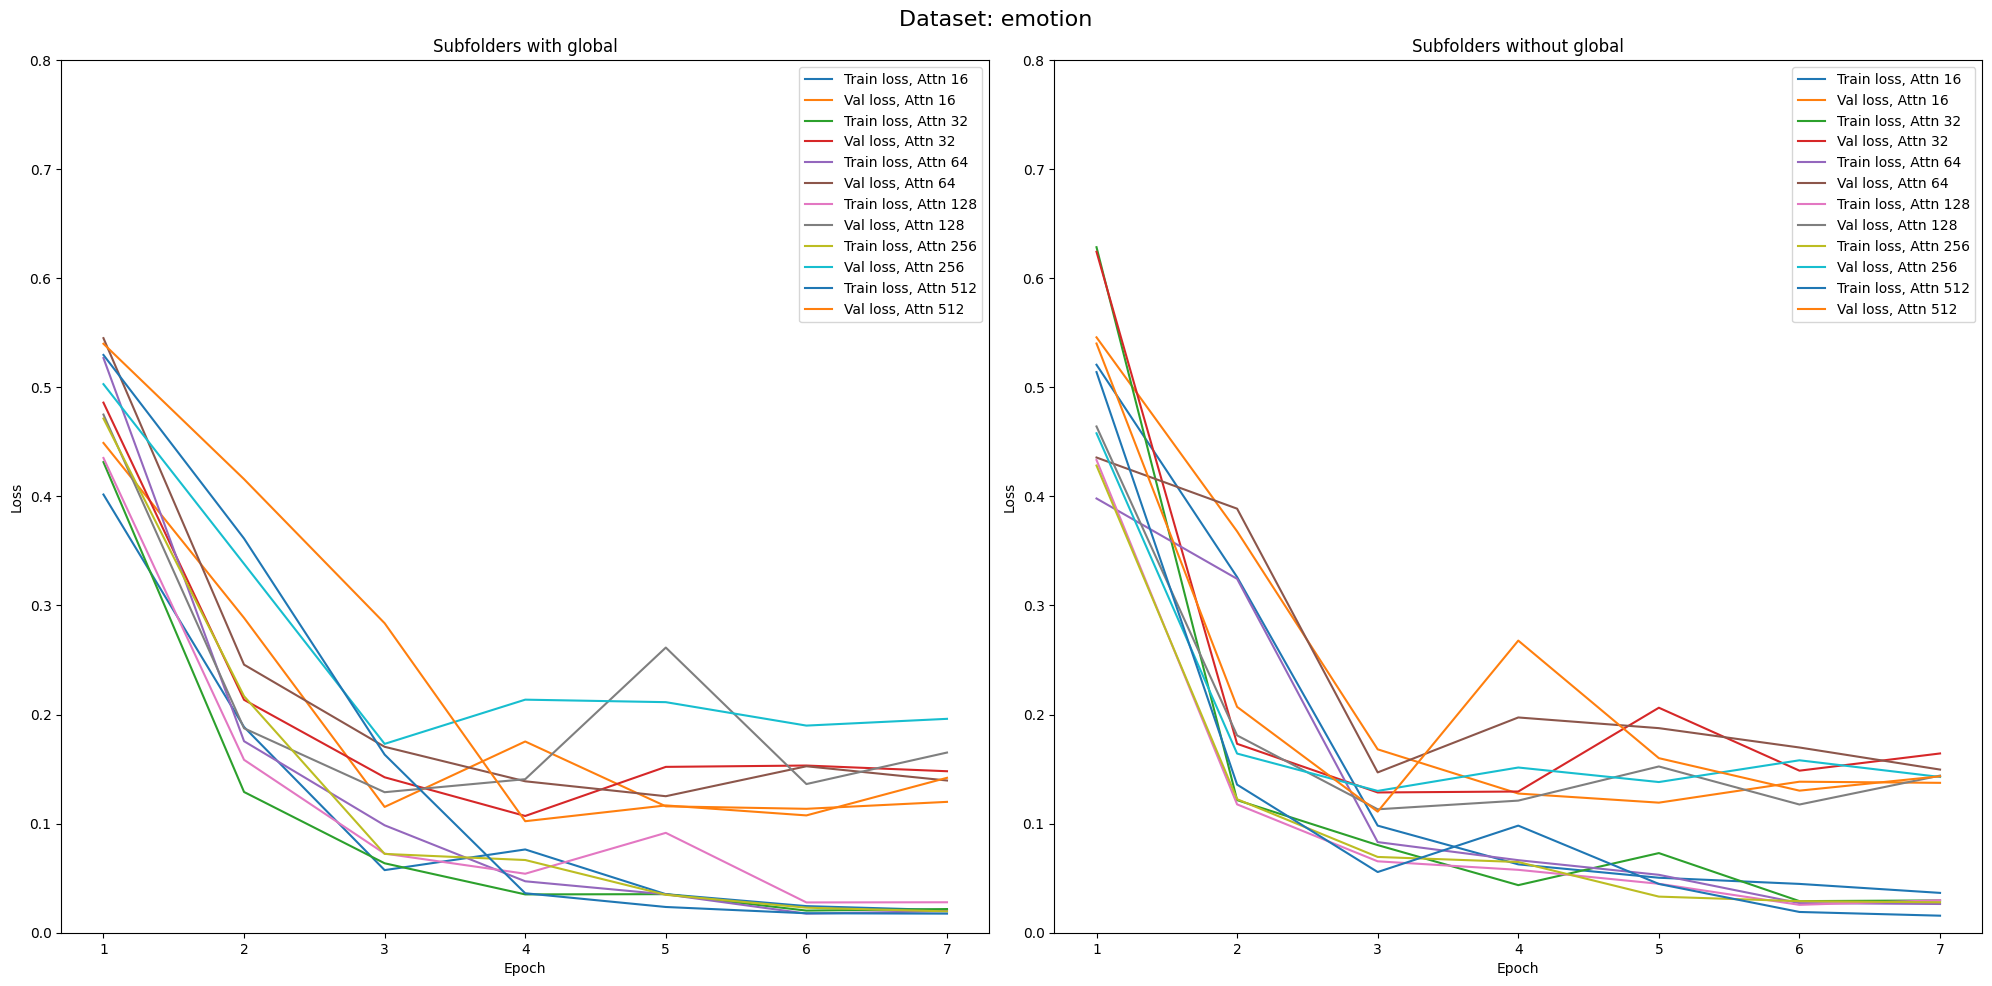

In [14]:
plot_comparinson_global(['emotion', 'epochs-7'], 'loss')

In [16]:
def plot_training_process(contain, metric):
    if isinstance(contain, str):
        contain = [contain]

    subfolders = [f.path for f in os.scandir('.') if f.is_dir() and all(c in f.path for c in contain)]
    subfolders = sorted(subfolders, key=lambda x: extract_att_win_size(x, contain))

    subfolders_with_global = [sf for sf in subfolders if 'no_global' not in sf]
    subfolders_without_global = [sf for sf in subfolders if 'no_global' in sf]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, subfolder in enumerate(zip(subfolders_with_global, subfolders_without_global)):
        subfolder_global, subfolder_without_global = subfolder
        train_res_global = pd.read_csv(os.path.join(subfolder_global, 'train_losses.csv'))
        val_res_global = pd.read_csv(os.path.join(subfolder_global, 'val_losses.csv'))
        train_res_wo_global = pd.read_csv(os.path.join(subfolder_without_global, 'train_losses.csv'))
        val_res_wo_global = pd.read_csv(os.path.join(subfolder_without_global, 'val_losses.csv'))
        
        att_win_size = extract_att_win_size(subfolder_global, contain)
        
        axes[idx].plot(train_res_global['epoch'], train_res_global['train_' + metric], label=f'Train with global')
        axes[idx].plot(val_res_global['epoch'], val_res_global['eval_' + metric], label=f'Val with global')
        axes[idx].plot(train_res_wo_global['epoch'], train_res_wo_global['train_' + metric], label=f'Train without global')
        axes[idx].plot(val_res_wo_global['epoch'], val_res_wo_global['eval_' + metric], label=f'Val without global')
        title = f"Attention Window Size: {att_win_size}"
        axes[idx].set_title(title, fontsize=15)
        axes[idx].set_xlabel('Epoch')
        if metric == 'loss':
            axes[idx].set_ylim(0, 0.85)
        else:
            axes[idx].set_ylim(0.5, 1)
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()

    dataset = subfolders[0].split('-')[5]
    fig.suptitle(f'Dataset: {dataset}', fontsize=20)

    plt.tight_layout(pad=1)
    plt.show()

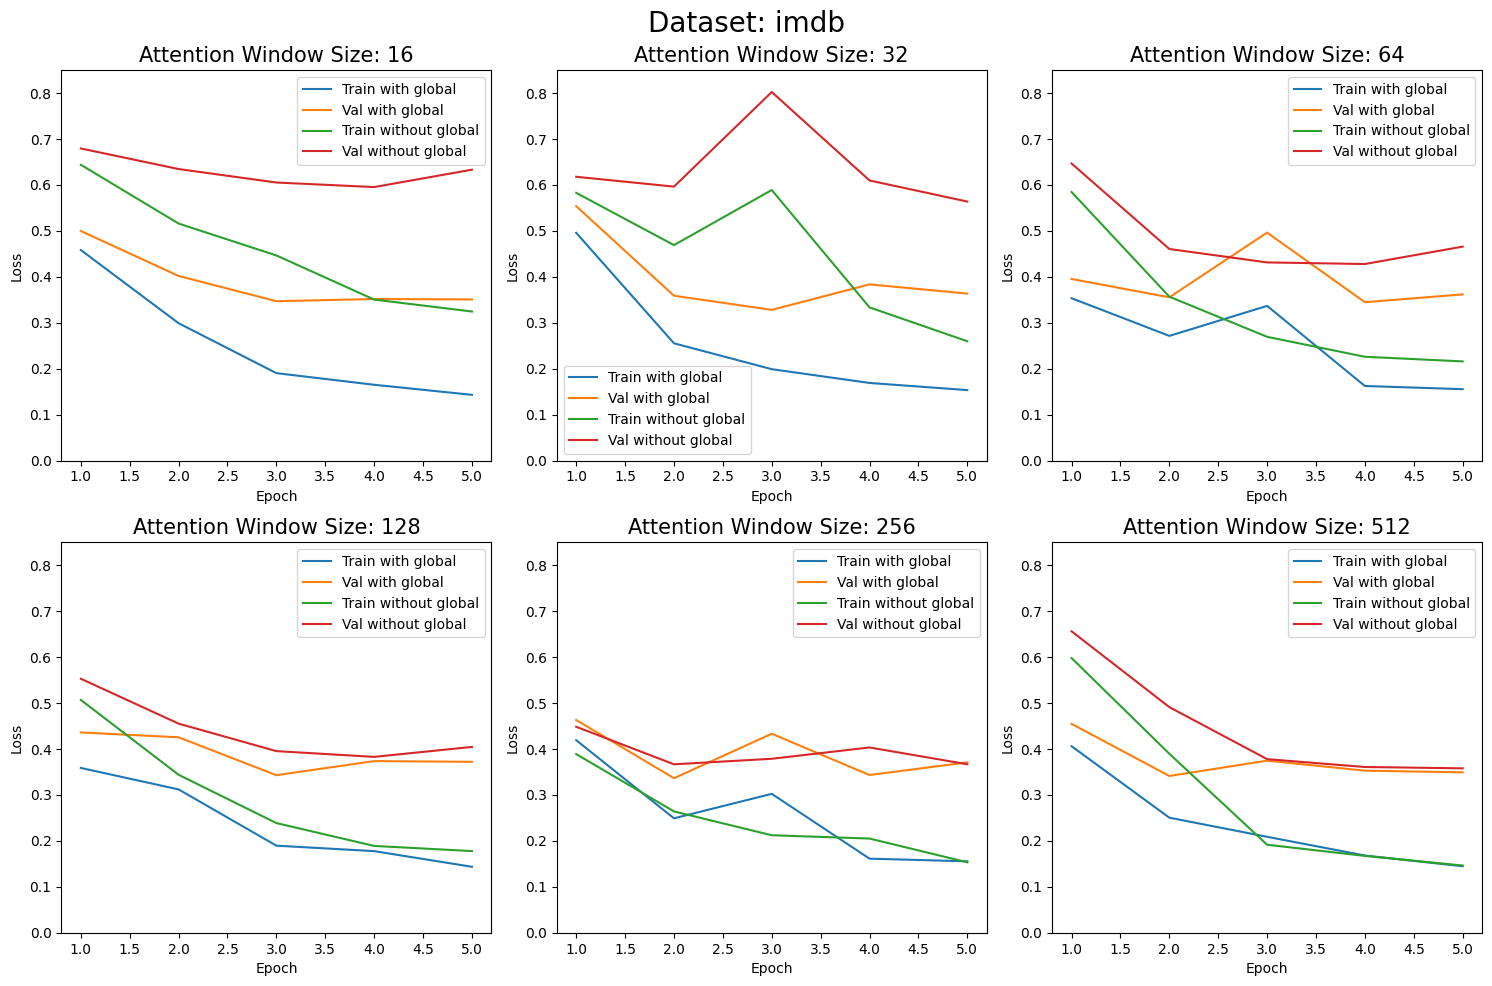

In [17]:
plot_training_process(['imdb', 'epochs-5'], 'loss')

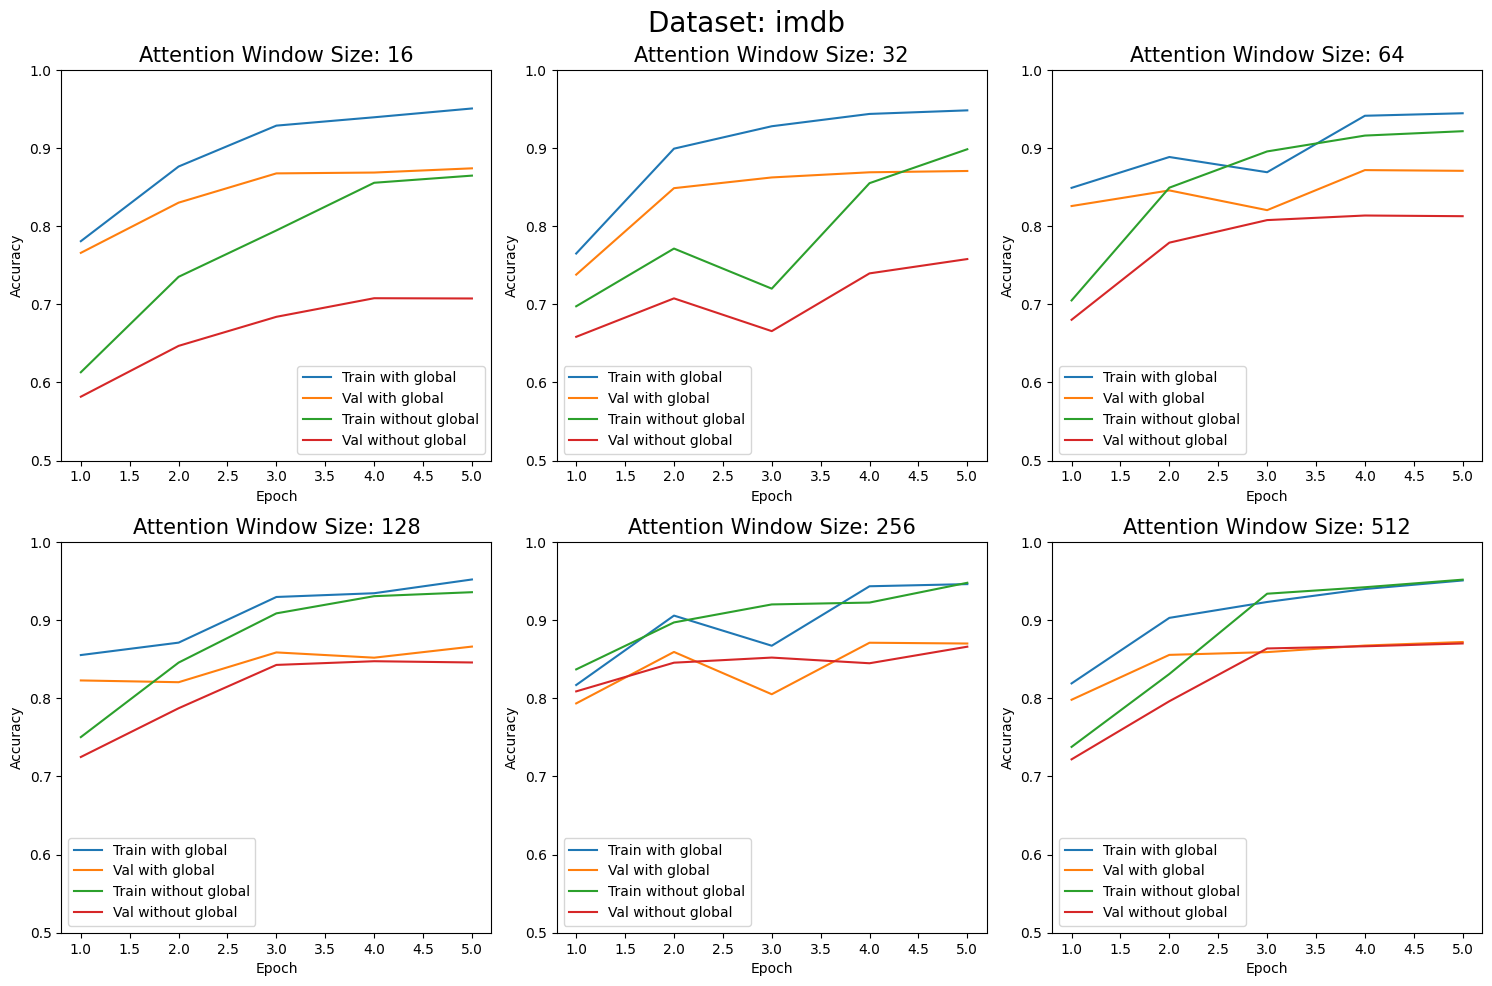

In [18]:
plot_training_process(['imdb', 'epochs-5'], 'accuracy')

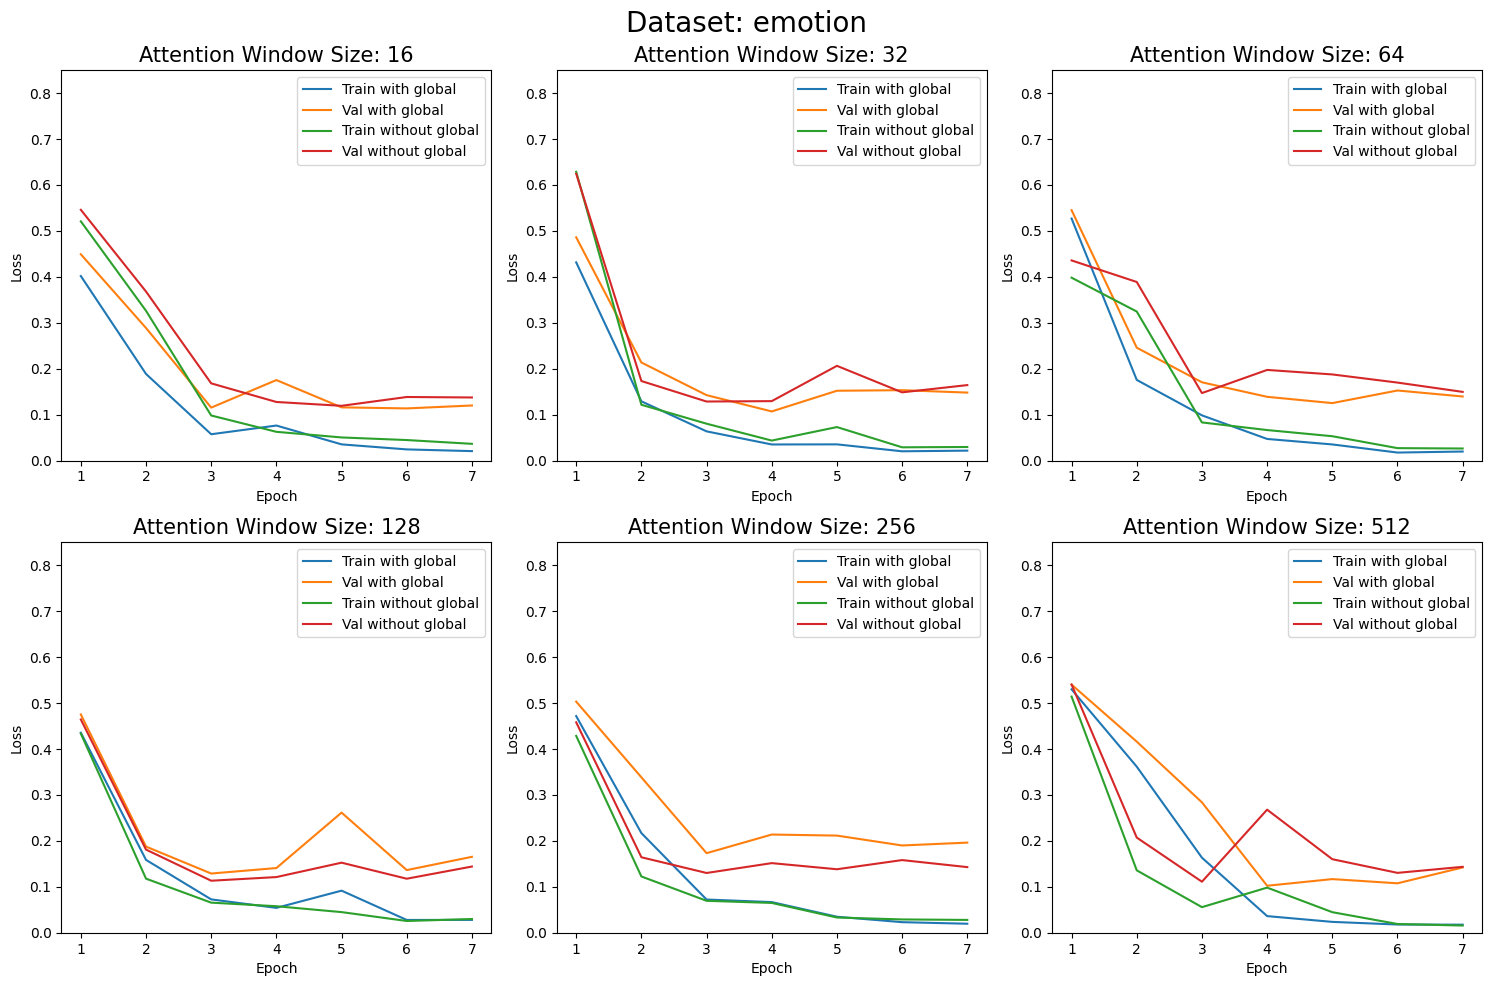

In [19]:
plot_training_process(['emotion', 'epochs-7'], 'loss')

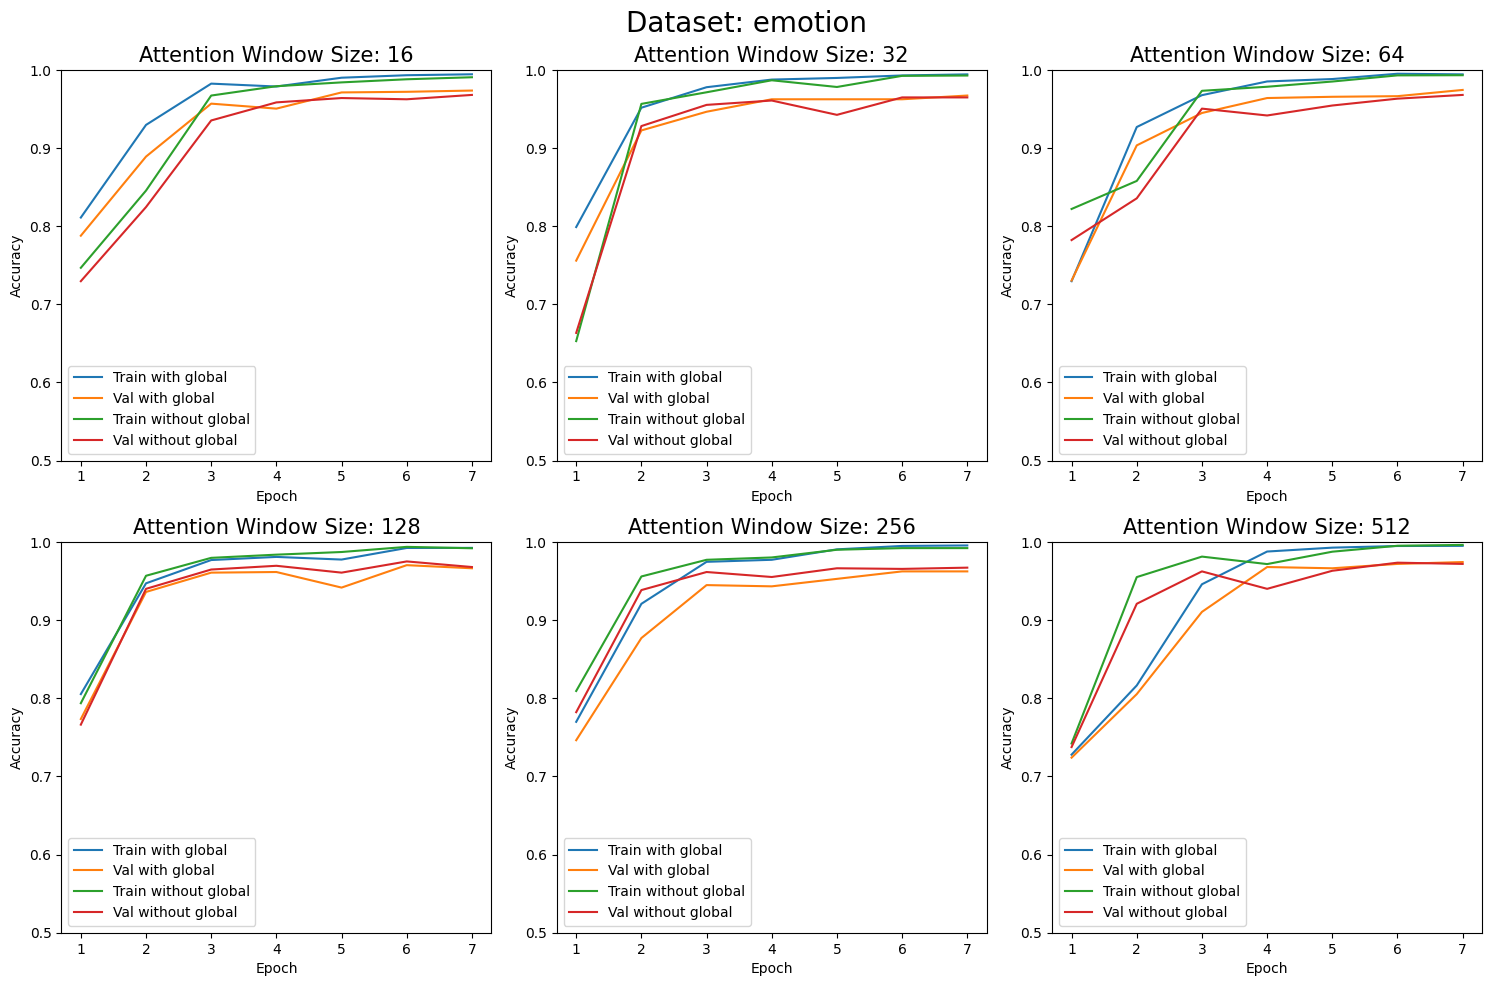

In [20]:
plot_training_process(['emotion', 'epochs-7'], 'accuracy')

# Comparison after running all trainings
- Adam, AdamW, SGD
- sliding attention, sliding + sparse attention

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def plot_statistics(dataset_name, metric, dataset_samples={}):
    df = pd.read_csv('extracted_features.csv')
    filtered_df = df[df['Dataset'] == dataset_name]
    
    attention_types = filtered_df['Attention Type'].unique()
    optimizers = filtered_df['Optimizer'].unique()

    window_sizes = sorted(filtered_df['Window Size'].unique())

    fig, ax = plt.subplots(figsize=(10, 6))
    for att_type in attention_types:
        for opt in optimizers:
            subset_df = filtered_df[(filtered_df['Attention Type'] == att_type) & (filtered_df['Optimizer'] == opt)]
            res = subset_df.set_index('Window Size')[metric].reindex(window_sizes)
            ax.plot(window_sizes, res, marker='o', linestyle='-', label=f'{opt}, {att_type}')
    
    ax.set_xlabel('Attention Window Size')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} vs Attention Window Size on {dataset_name} Dataset')
    ax.legend()
    
    plt.tight_layout(pad=1)
    plt.show()

## Memory Usage

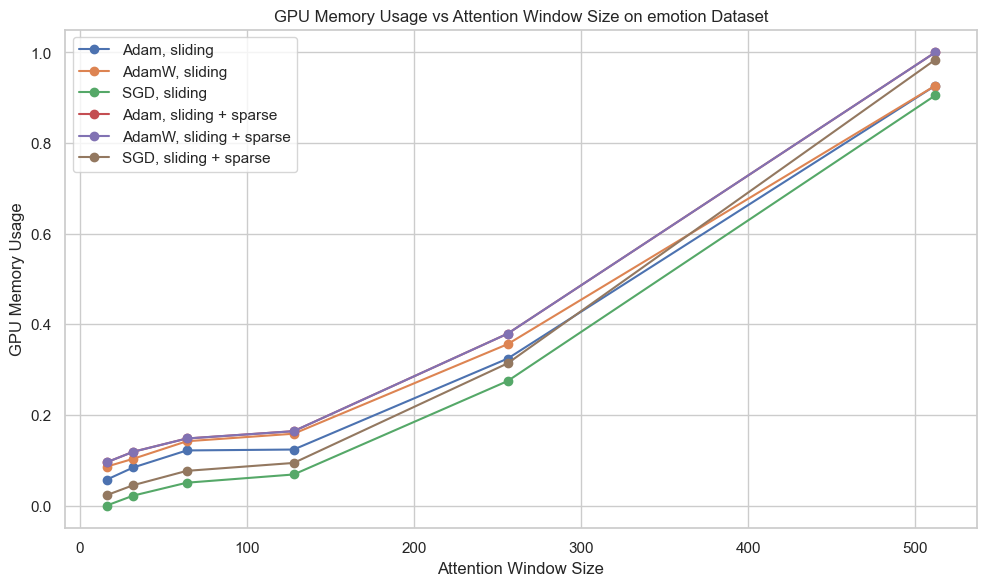

In [118]:
plot_statistics('emotion', 'GPU Memory Usage')

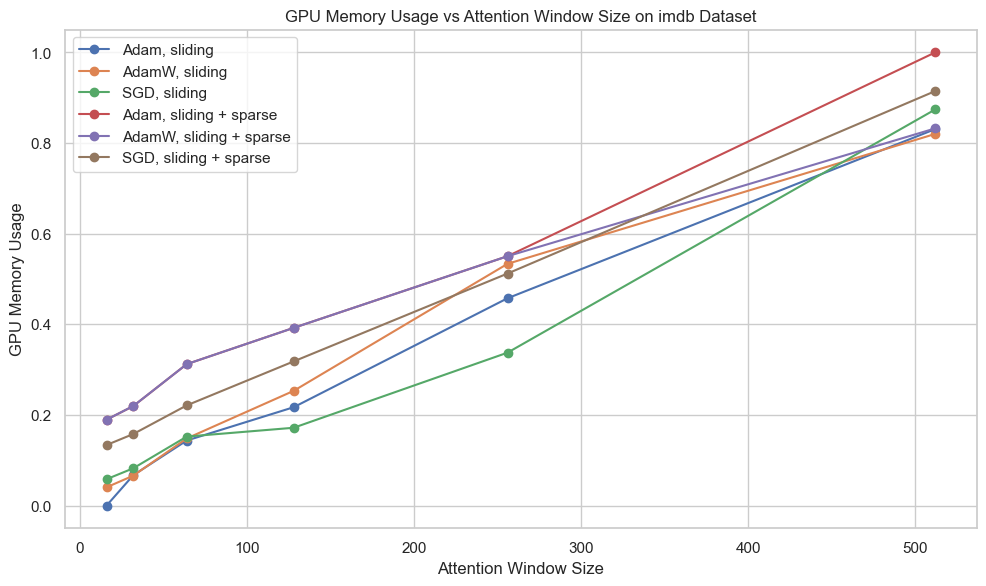

In [119]:
plot_statistics('imdb', 'GPU Memory Usage')

## Training Time

In [120]:
from datasets import Dataset, load_dataset
from sklearn.model_selection import train_test_split

def stratified_split(dataset, n_samples):
    df = dataset.to_pandas()
    df_0 = df[df["label"] == 0]
    df_1 = df[df["label"] == 1]

    sample_0, _ = train_test_split(
        df_0, train_size=n_samples // 2, stratify=df_0["label"], random_state=42
    )
    sample_1, _ = train_test_split(
        df_1, train_size=n_samples // 2, stratify=df_1["label"], random_state=42
    )

    sample = pd.concat([sample_0, sample_1])
    remaining = df.drop(sample.index)

    return Dataset.from_pandas(sample), Dataset.from_pandas(remaining)

def filter_labels(example):
    return example["label"] in [0, 1]
    
def count_no_samples():
    dataset_samples = {}
    
    name = "imdb"
    dataset = load_dataset(name)
    _, new_train = stratified_split(dataset['train'], 7500)
    dataset_samples[name] = len(new_train)

    name = "emotion"
    dataset = load_dataset('dair-ai/' + name)
    dataset_samples[name] = len(dataset["train"].filter(filter_labels))
    
    return dataset_samples

dataset_samples = count_no_samples()
dataset_samples

{'imdb': 17500, 'emotion': 10028}

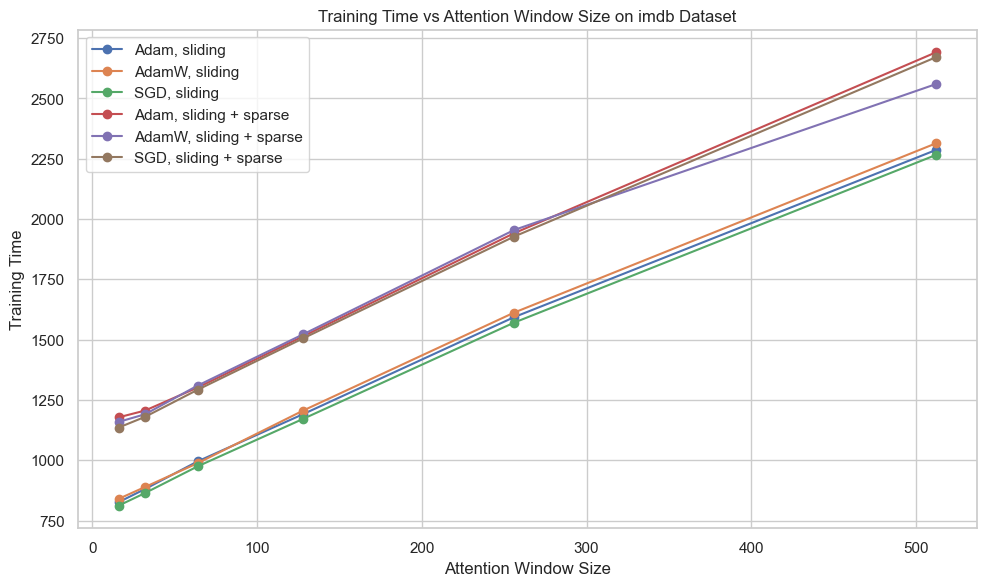

In [121]:
plot_statistics('imdb', 'Training Time', dataset_samples)

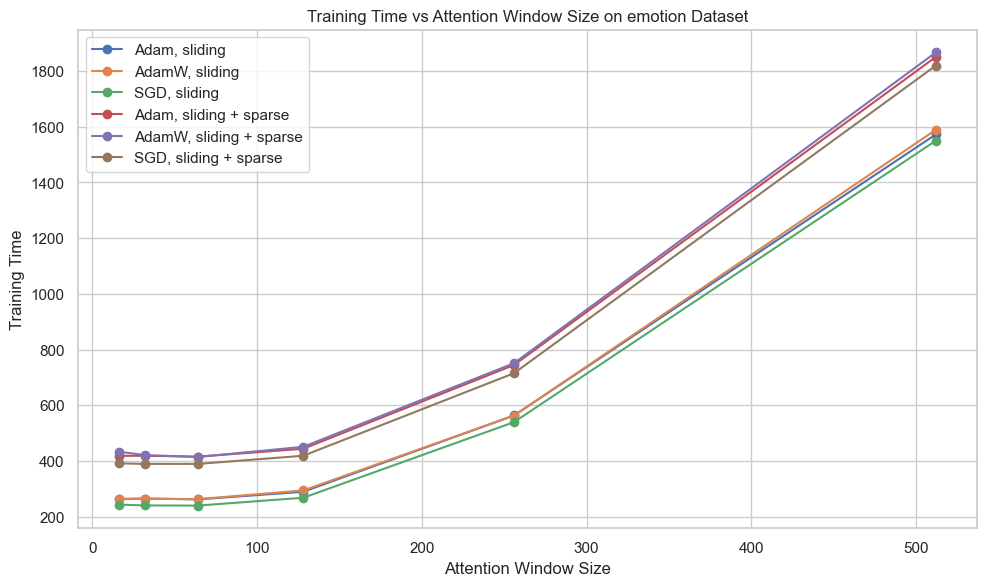

In [122]:
plot_statistics('emotion', 'Training Time', dataset_samples)

## Test Accuracy

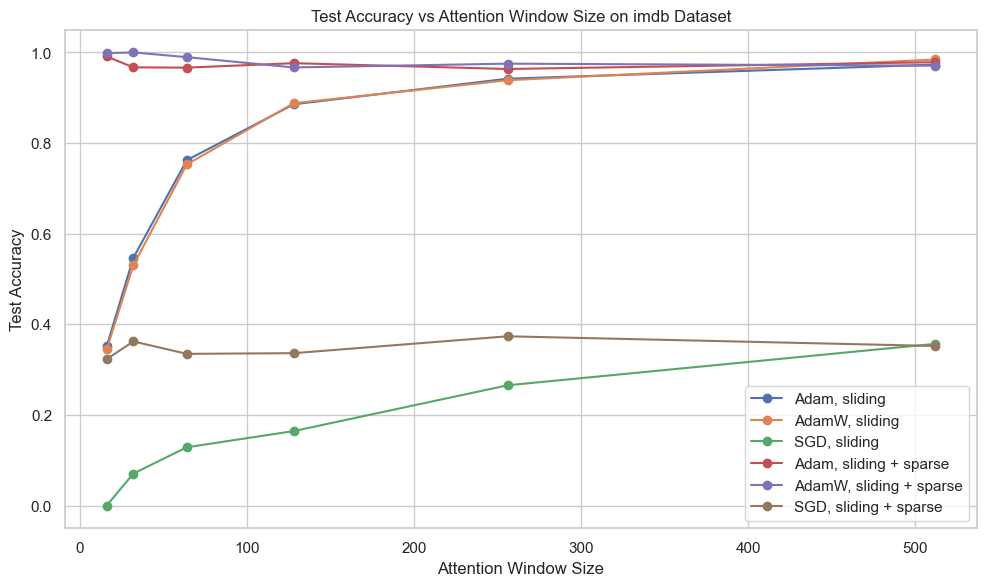

In [123]:
plot_statistics('imdb', 'Test Accuracy')

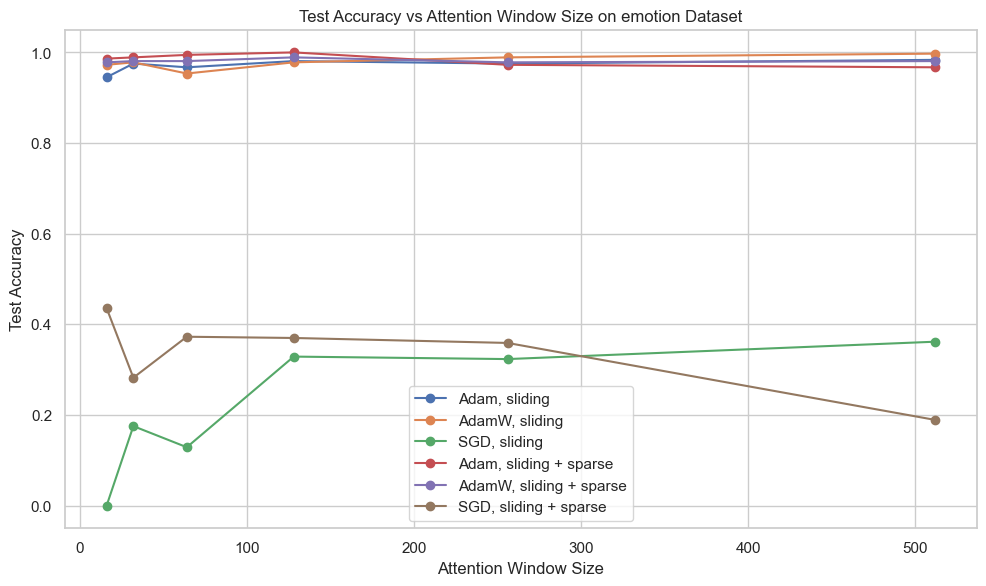

In [124]:
plot_statistics('emotion', 'Test Accuracy')

## Cost Results

### Emotion

In [125]:
import seaborn as sns
sns.set(style="whitegrid")

def plot_heatmaps(df):
    cost_functions = ['Cost Function (0.25, 0.75)', 'Cost Function (0.5, 0.5)', 'Cost Function (0.75, 0.25)']
    
    for cost_function in cost_functions:
        df_pivot = df.pivot(index='Combination', columns='Window Size', values=cost_function)
        plt.figure(figsize=(12, 6))
        sns.heatmap(df_pivot, annot=True, fmt=".4g", cmap='viridis')
        plt.title(f'{cost_function}')
        plt.show()

def plot_bar_plots(df, cost_function):
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='Window Size', 
        y=cost_function, 
        hue='Combination', 
        data=df, 
        # palette='viridis'
    )
    plt.title(f'Comparison of {cost_function} Across Different Combinations of Attention Types and Optimizers')
    plt.ylabel(cost_function)
    plt.yscale('log')
    plt.legend(title='Combination', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_scatter_plots(df):
    combinations = df[['Attention Type', 'Optimizer']].drop_duplicates()
    cost_functions = ['Cost Function (0.25, 0.75)', 'Cost Function (0.5, 0.5)', 'Cost Function (0.75, 0.25)']
    
    for i, cost_func in enumerate(cost_functions):
        plt.figure(figsize=(10, 6))
        plt.title(f'Cost Function: {cost_func}')
        plt.xlabel('Window Size')
        plt.ylabel('Cost Function Value')
        
        for index, row in combinations.iterrows():
            subset = df[(df['Attention Type'] == row['Attention Type']) & (df['Optimizer'] == row['Optimizer'])]
            plt.scatter(subset['Window Size'], subset[cost_func], label=f"{row['Attention Type']} + {row['Optimizer']}")
        
        plt.legend()
        plt.grid(True)
        plt.show()

In [126]:
df = pd.read_csv('extracted_features.csv')
filtered_df = df[df['Dataset'] == 'emotion'][['Attention Type', 'Optimizer', 'Window Size', 'Cost Function (0.25, 0.75)', 'Cost Function (0.5, 0.5)', 'Cost Function (0.75, 0.25)']]

filtered_df['Combination'] =filtered_df['Attention Type'] + ', ' + filtered_df['Optimizer']

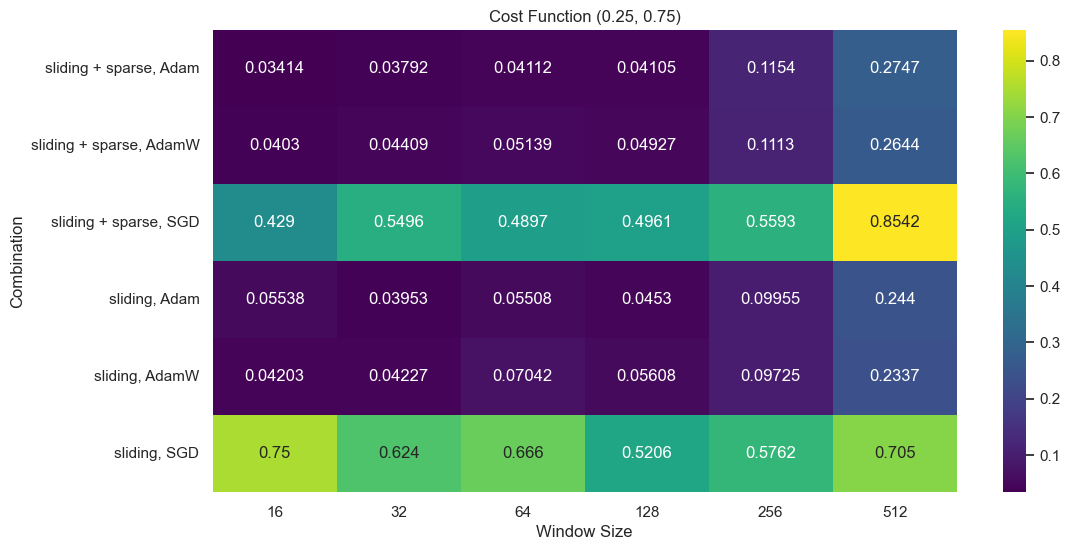

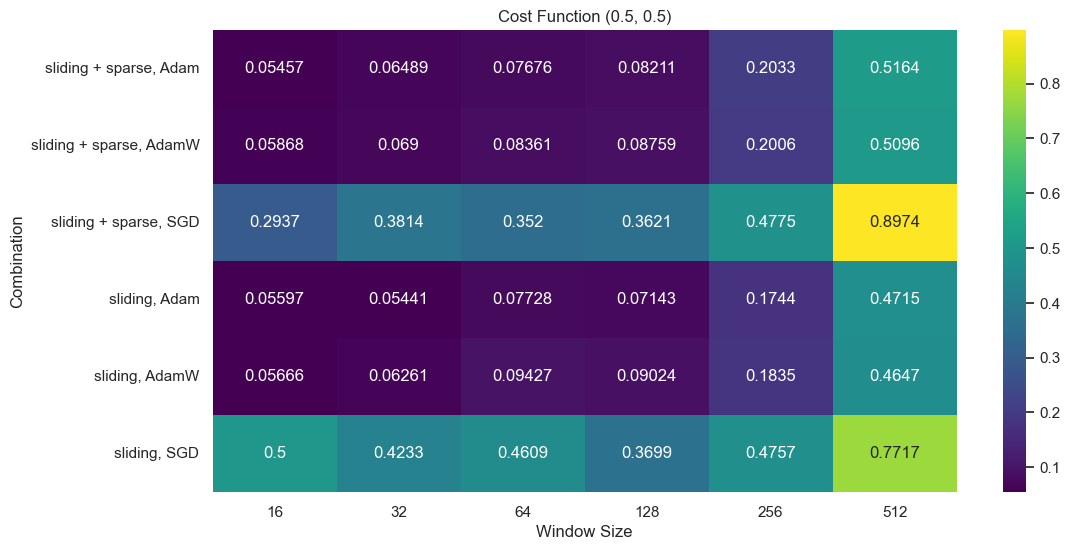

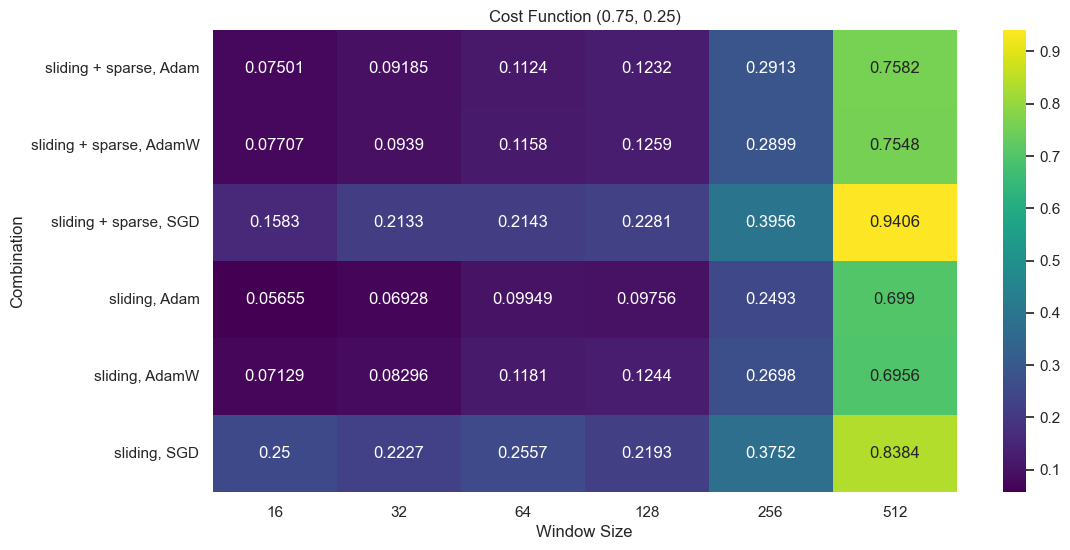

In [128]:
plot_heatmaps(filtered_df)

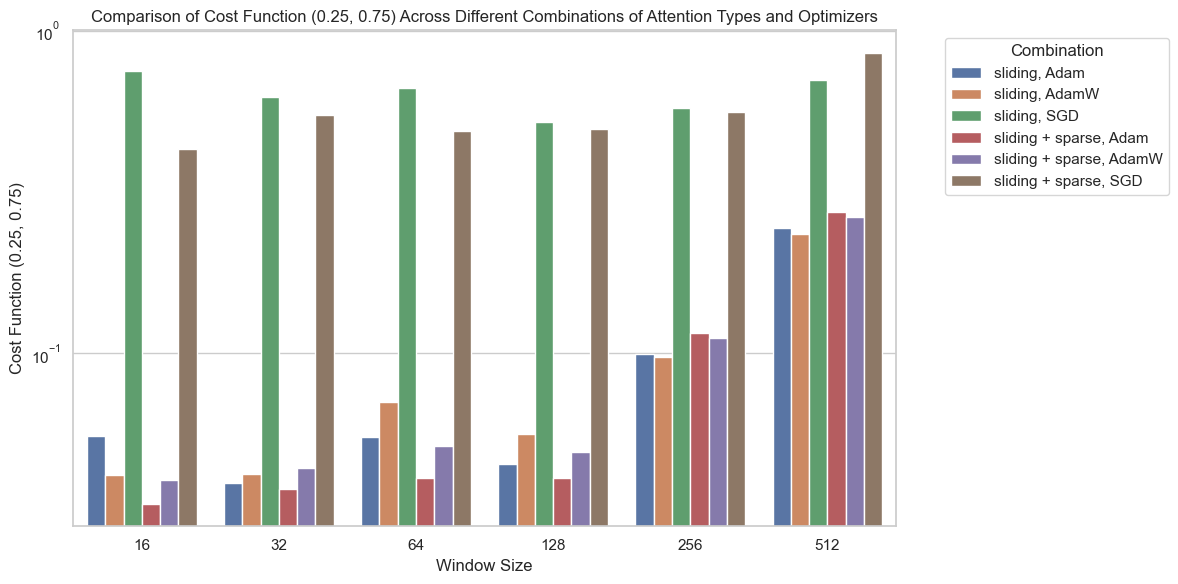

In [129]:
plot_bar_plots(filtered_df, 'Cost Function (0.25, 0.75)')

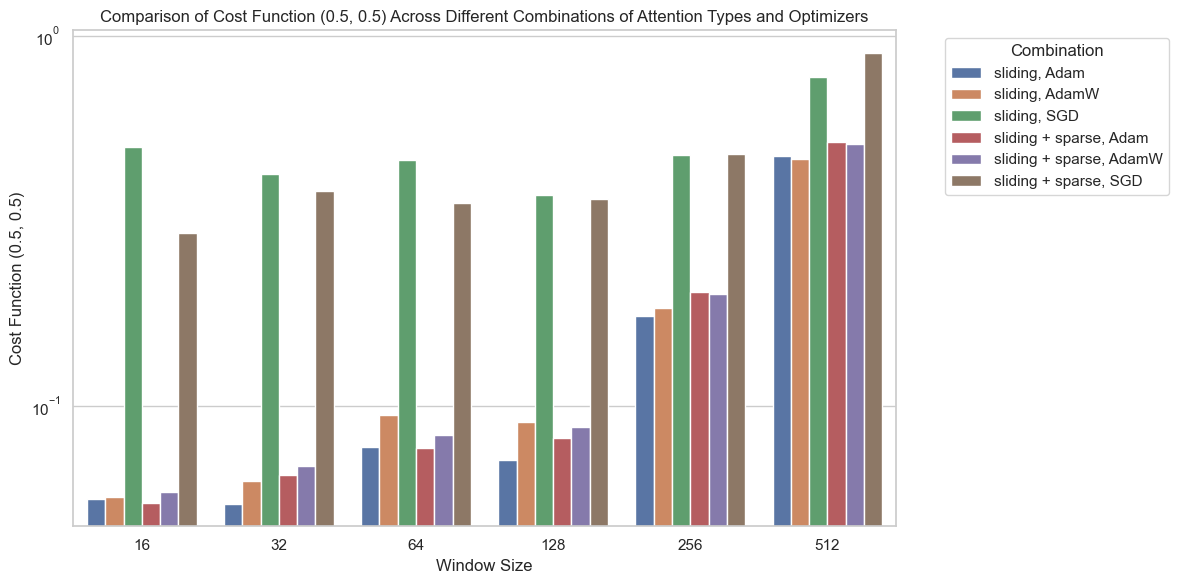

In [130]:
plot_bar_plots(filtered_df, 'Cost Function (0.5, 0.5)')

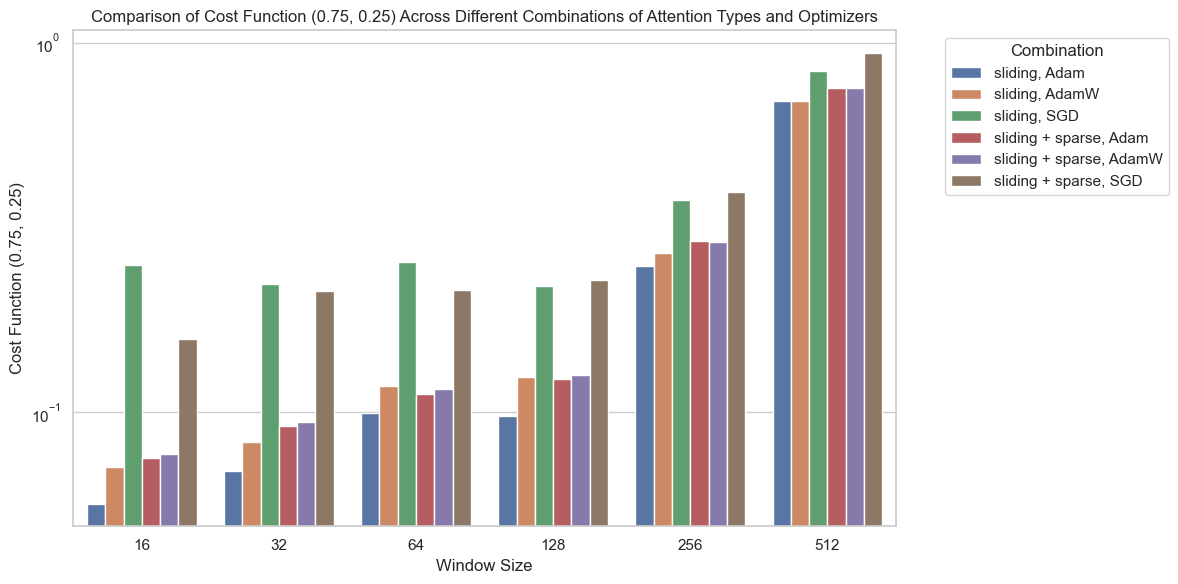

In [131]:
plot_bar_plots(filtered_df, 'Cost Function (0.75, 0.25)')

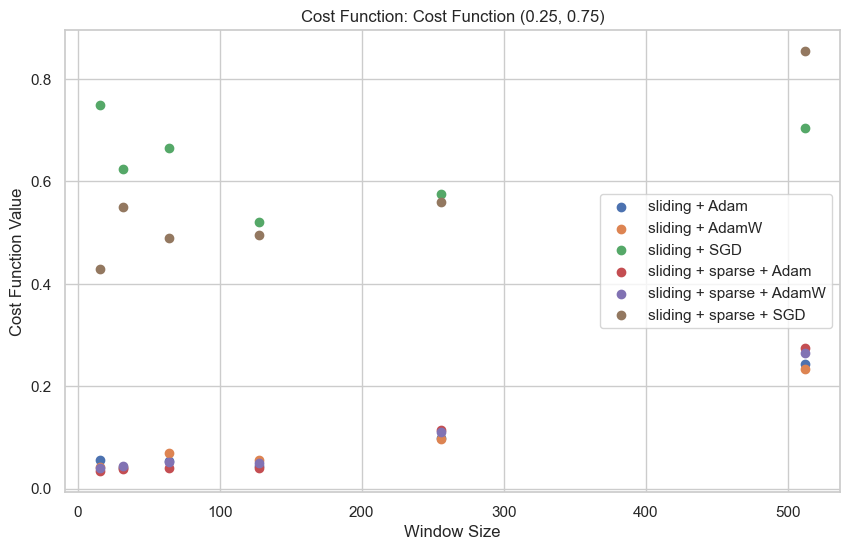

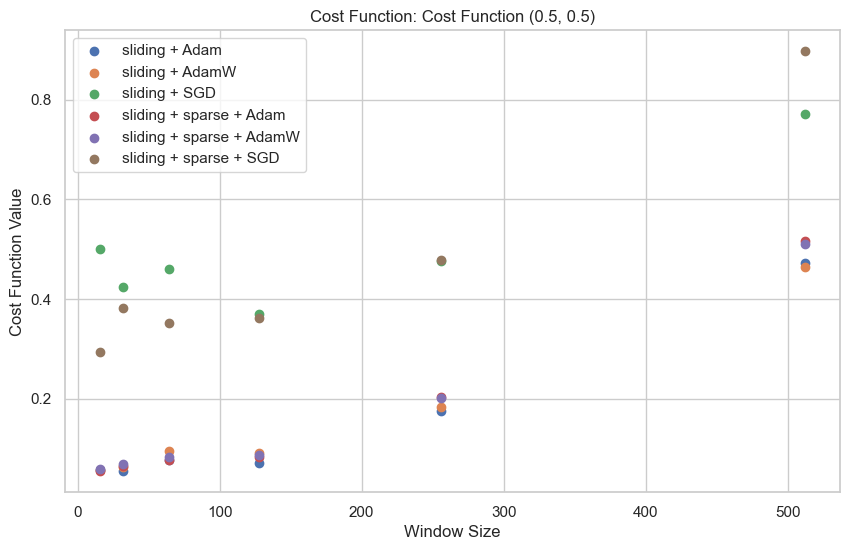

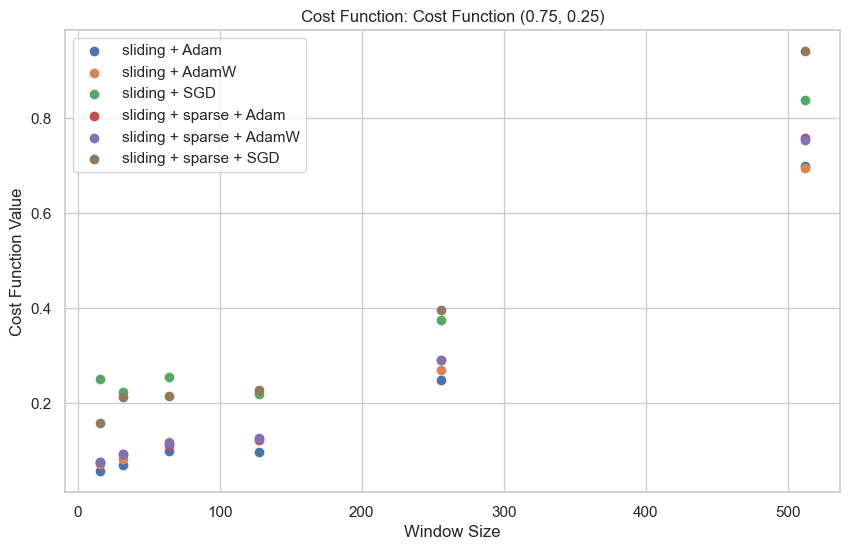

In [132]:
plot_scatter_plots(filtered_df)

### IMDB

In [133]:
df = pd.read_csv('extracted_features.csv')
filtered_df = df[df['Dataset'] == 'imdb'][['Attention Type', 'Optimizer', 'Window Size', 'Cost Function (0.25, 0.75)', 'Cost Function (0.5, 0.5)', 'Cost Function (0.75, 0.25)']]

filtered_df['Combination'] =filtered_df['Attention Type'] + ', ' + filtered_df['Optimizer']

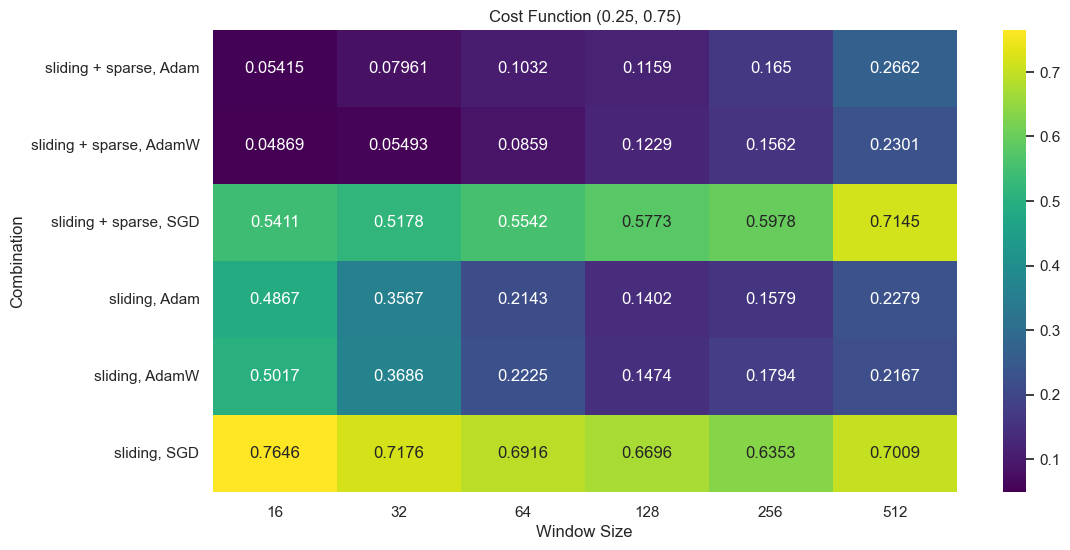

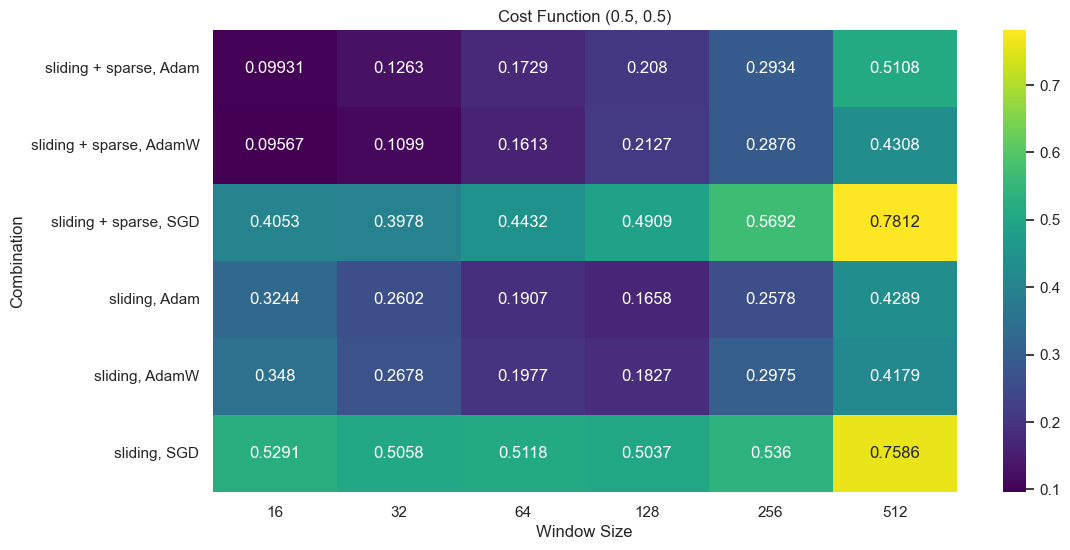

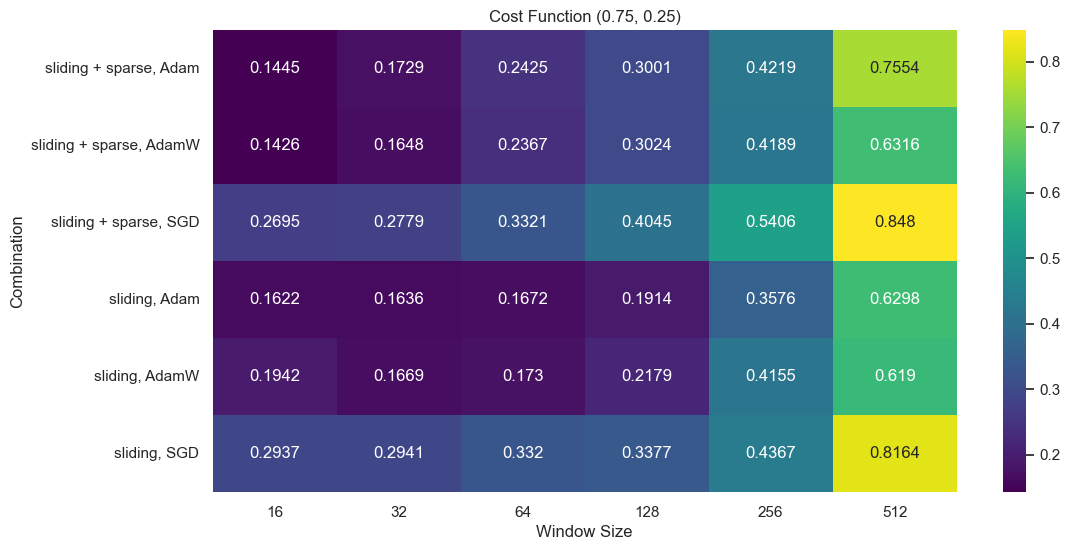

In [134]:
plot_heatmaps(filtered_df)

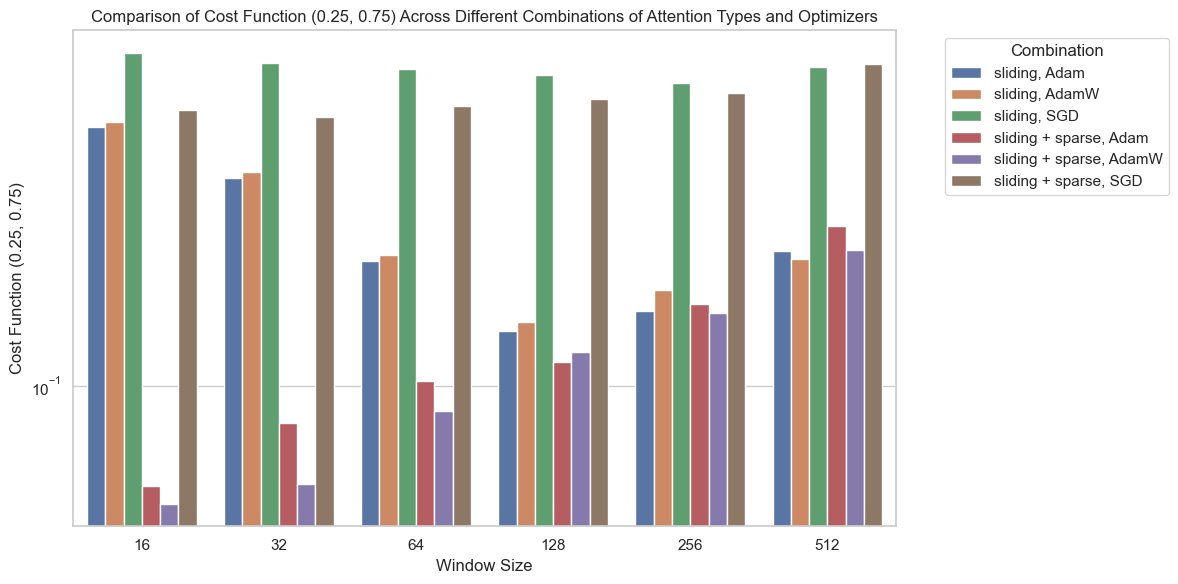

In [135]:
plot_bar_plots(filtered_df, 'Cost Function (0.25, 0.75)')

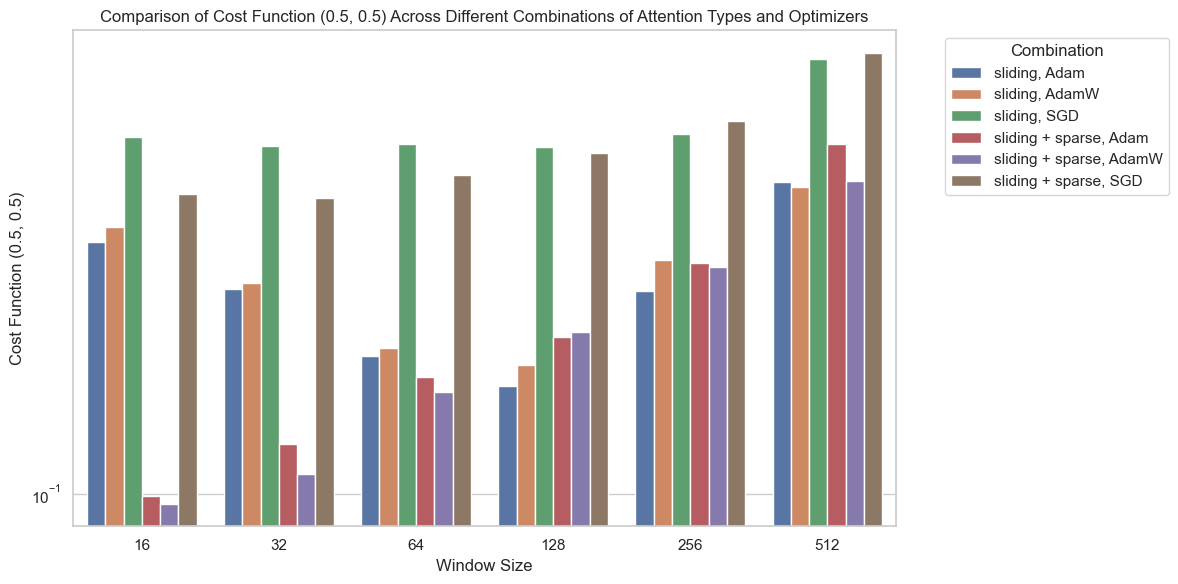

In [136]:
plot_bar_plots(filtered_df, 'Cost Function (0.5, 0.5)')

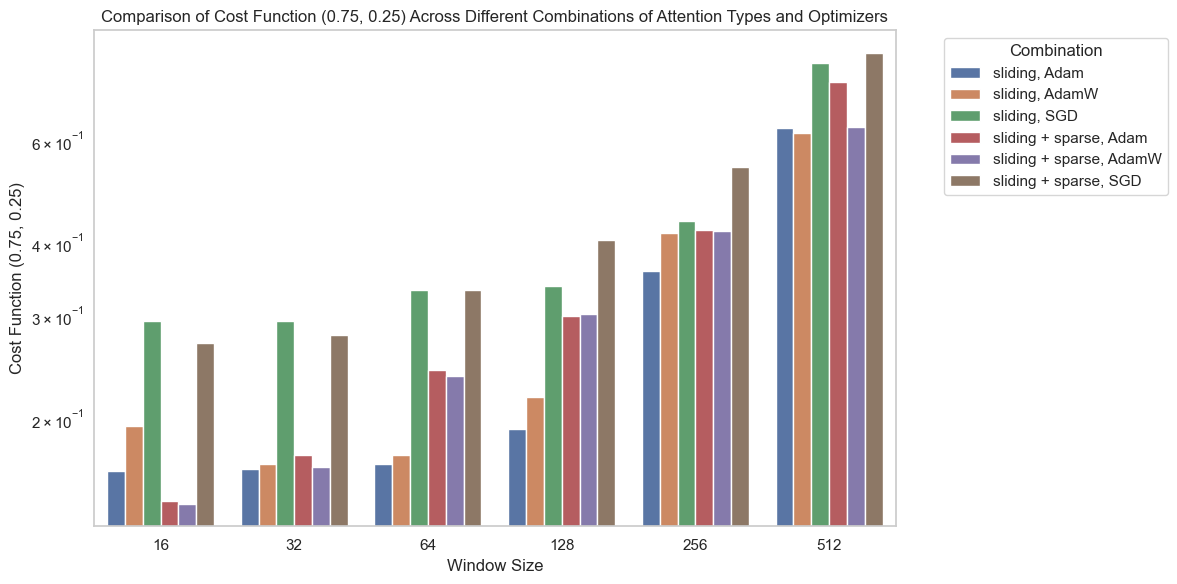

In [137]:
plot_bar_plots(filtered_df, 'Cost Function (0.75, 0.25)')

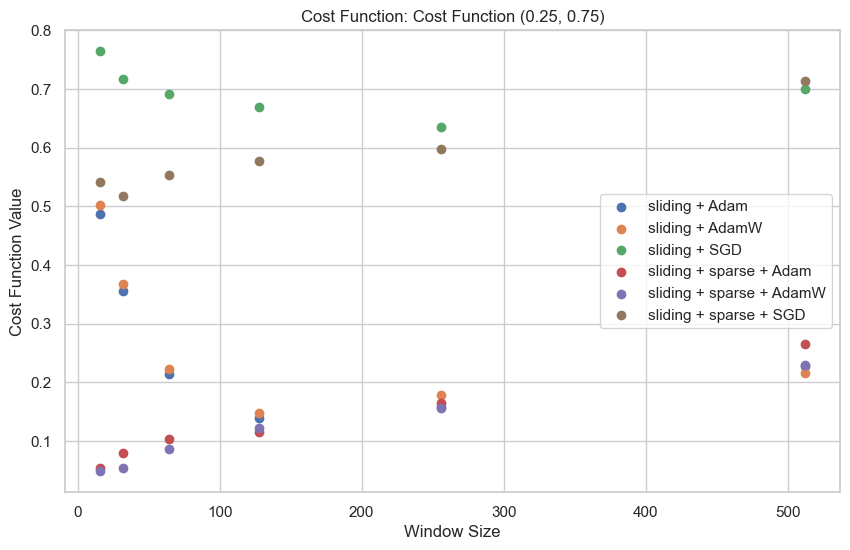

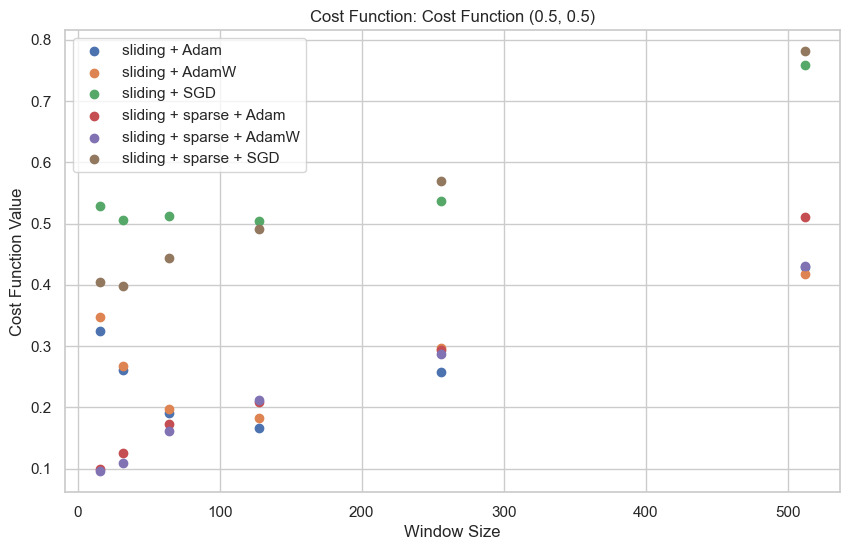

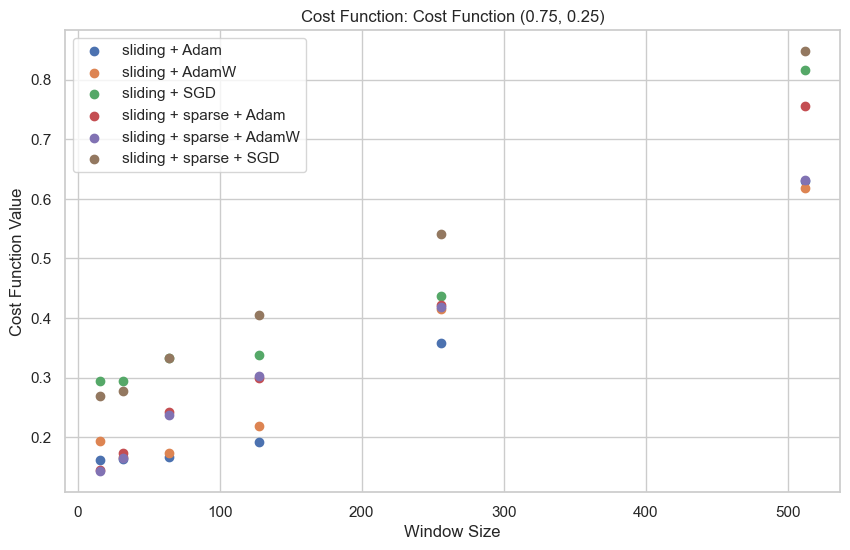

In [138]:
plot_scatter_plots(filtered_df)

# Tests

In [141]:
df = pd.read_csv('extracted_features.csv')
filtered_df = df[df['Dataset'] == 'emotion'][['Attention Type', 'Optimizer', 'Window Size', 'Cost Function (0.25, 0.75)', 'Cost Function (0.5, 0.5)', 'Cost Function (0.75, 0.25)']]

In [142]:
filtered_df.sort_values(by=['Attention Type', 'Optimizer', 'Window Size'])

Attention Type Optimizer  Window Size  Cost Function (0.25, 0.75)  \
1            sliding      Adam           16                    0.055380   
3            sliding      Adam           32                    0.039532   
5            sliding      Adam           64                    0.055081   
0            sliding      Adam          128                    0.045305   
2            sliding      Adam          256                    0.099547   
4            sliding      Adam          512                    0.243975   
7            sliding     AdamW           16                    0.042030   
9            sliding     AdamW           32                    0.042266   
11           sliding     AdamW           64                    0.070420   
6            sliding     AdamW          128                    0.056080   
8            sliding     AdamW          256                    0.097246   
10           sliding     AdamW          512                    0.233701   
13           sliding       SGD           16                    0.750000   
15           sliding       SGD           32                    0.624002   
17           sliding       SGD           64                    0.666048   
12           sliding       SGD          128                    0.520588   
14           sliding       SGD          256                    0.576214   
16           sliding       SGD          512                    0.705043   
19  sliding + sparse      Adam           16                    0.034136   
21  sliding + sparse      Adam           32                    0.037922   
23  sliding + sparse      Adam           64                    0.041121   
18  sliding + sparse      Adam          128                    0.041053   
20  sliding + sparse      Adam          256                    0.115360   
22  sliding + sparse      Adam          512                    0.274658   
25  sliding + sparse     AdamW           16                    0.040301   
27  sliding + sparse     AdamW           32                    0.044087   
29  sliding + sparse     AdamW           64                    0.051395   
24  sliding + sparse     AdamW          128                    0.049272   
26  sliding + sparse     AdamW          256                    0.111251   
28  sliding + sparse     AdamW          512                    0.264384   
31  sliding + sparse       SGD           16                    0.429018   
33  sliding + sparse       SGD           32                    0.549623   
35  sliding + sparse       SGD           64                    0.489704   
30  sliding + sparse       SGD          128                    0.496133   
32  sliding + sparse       SGD          256                    0.559274   
34  sliding + sparse       SGD          512                    0.854178   

    Cost Function (0.5, 0.5)  Cost Function (0.75, 0.25)  
1                   0.055966                    0.056551  
3                   0.054406                    0.069280  
5                   0.077284                    0.099488  
0                   0.071432                    0.097558  
2                   0.174437                    0.249327  
4                   0.471512                    0.699049  
7                   0.056662                    0.071294  
9                   0.062614                    0.082963  
11                  0.094265                    0.118110  
6                   0.090241                    0.124403  
8                   0.183533                    0.269820  
10                  0.464663                    0.695625  
13                  0.500000                    0.250000  
15                  0.423346                    0.222691  
17                  0.460863                    0.255678  
12                  0.369943                    0.219298  
14                  0.475716                    0.375218  
16                  0.771730                    0.838418  
19                  0.054574                    0.075011  
21                  0.064886                    0.